# Improve Performance of predicting churned customers

- A manager at the bank is disturbed with more and more customers leaving their credit card services. 

- Predict who is gonna get churned so they can proactively go to the customer to provide them better services and turn customers' decisions in the opposite direction.

- Our top priority in this business problem is to identify customers who are getting churned. Even if we predict non-churning customers as churned, it won't harm our business. But predicting churning customers as Non-churning will do. So recall (TP/TP+FN) need to be higher. Till now, I have managed to get a recall of 62%. Need better.


In [699]:
import numpy as np
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, roc_curve, auc

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

In [700]:
df = pd.read_csv('BankChurners.csv')
df = df.rename(columns={"Attrition_Flag": "Attrition"})
df.shape

(10127, 23)

In [701]:
df.columns

Index(['CLIENTNUM', 'Attrition', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

In [702]:
df = df.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', axis=1)
df = df.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', axis=1)
df = df.drop('CLIENTNUM', axis=1)
df.shape

(10127, 20)

In [703]:
df.columns

Index(['Attrition', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [704]:
df.isnull().sum()

Attrition                   0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [705]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition                 10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [706]:
print(df.groupby('Attrition').count()['Gender'])
print(df.groupby('Card_Category').count()['Attrition'])
print(df.groupby('Marital_Status').count()['Attrition'])
print(df.groupby('Income_Category').count()['Attrition'])

Attrition
Attrited Customer    1627
Existing Customer    8500
Name: Gender, dtype: int64
Card_Category
Blue        9436
Gold         116
Platinum      20
Silver       555
Name: Attrition, dtype: int64
Marital_Status
Divorced     748
Married     4687
Single      3943
Unknown      749
Name: Attrition, dtype: int64
Income_Category
$120K +            727
$40K - $60K       1790
$60K - $80K       1402
$80K - $120K      1535
Less than $40K    3561
Unknown           1112
Name: Attrition, dtype: int64


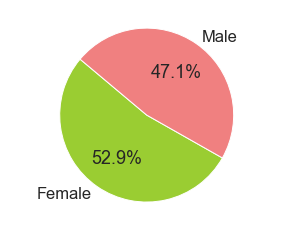

In [707]:
fig, ax = plt.subplots(figsize = (5,4)) 
colors = ['yellowgreen', 'lightcoral']
plt.axis('equal')
plt.pie(df.groupby('Gender').count()['Attrition'], labels=['Female', 'Male'], colors=colors, autopct='%1.1f%%', startangle=140)
plt.show()

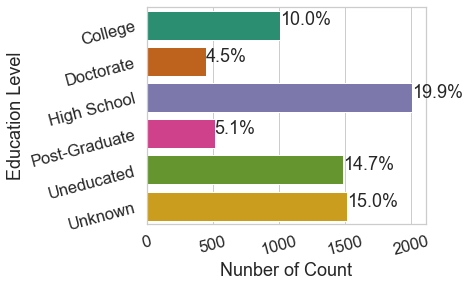

In [708]:
fig, ax = plt.subplots(figsize = (5,4)) 
sns.countplot(y=df["Education_Level"], order= ['College', 'Doctorate', 'High School', 'Post-Graduate', 'Uneducated', 'Unknown'], palette = "Dark2")

total = len(df['Education_Level'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.xticks(rotation =15)
plt.yticks(rotation =15)
plt.ylabel('Education Level')
plt.xlabel('Nunber of Count')
plt.show()

In [709]:
df.Attrition.replace({'Existing Customer': 1, 'Attrited Customer': 0}, inplace=True)
df.Gender.replace({'F': 1, 'M': 0}, inplace=True)
df.Education_Level.replace({'Graduate': 0, 'High School': 1, 'Unknown': 2,'Uneducated':3,'College':4,'Post-Graduate':5,'Doctorate':6}, inplace=True)
df.Card_Category.replace({'Blue': 0, 'Silver': 1,'Platinum':2, 'Gold':3}, inplace=True)
df.Marital_Status.replace({'Married': 0, 'Single': 1,'Unknown':2,'Divorced':3}, inplace=True)
df.Income_Category.replace({'Unknown': 0,'Less than $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3, '$80K - $120K': 4, '$120K +': 5}, inplace=True)

df.head()

,Attrition,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,1,45,0,3,1,0,3,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,49,1,5,0,1,1,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,1,51,0,3,0,0,4,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,1,40,1,4,1,2,1,0,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,1,40,0,3,3,0,3,0,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [710]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition                 10127 non-null  int64  
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  int64  
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  int64  
 5   Marital_Status            10127 non-null  int64  
 6   Income_Category           10127 non-null  int64  
 7   Card_Category             10127 non-null  int64  
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

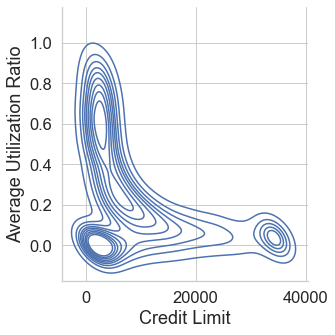

In [712]:
sns.displot(df, x="Credit_Limit", y="Avg_Utilization_Ratio", kind="kde")
plt.xlabel('Credit Limit')
plt.ylabel('Average Utilization Ratio')
plt.show()

In [713]:
df.head()

,Attrition,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,1,45,0,3,1,0,3,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,49,1,5,0,1,1,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,1,51,0,3,0,0,4,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,1,40,1,4,1,2,1,0,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,1,40,0,3,3,0,3,0,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [714]:
x = df.drop('Attrition', axis=1)
y = df['Attrition']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=44, shuffle =True)


# Logistic Regression

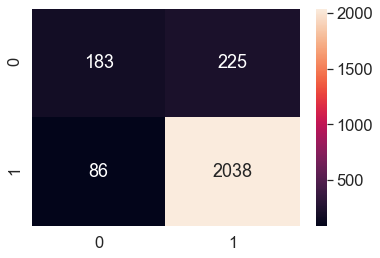

In [715]:
LR = LogisticRegression()
LR.fit(x_train, y_train)
y_pred = LR.predict(x_test)

Comparison = {}
_model_probabilities = LR.predict_proba(x_train)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_train, _model_probabilities)

Comparison['Logistic'] = [metrics.accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), false_positive_rate_values, sensitivity_values, roc_auc_score(y_test, y_pred)]

lr_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(lr_cm, annot=True, fmt="")
plt.show()

In [676]:
print(classification_report(y_test, y_pred))
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100.0))
print("Recall: %.2f%%" % (recall_score(y_test, y_pred)*100.0))


              precision    recall  f1-score   support

           0       0.68      0.45      0.54       408
           1       0.90      0.96      0.93      2124

    accuracy                           0.88      2532
   macro avg       0.79      0.70      0.73      2532
weighted avg       0.87      0.88      0.87      2532

Accuracy: 87.72%
Recall: 95.95%


# Decision Tree 

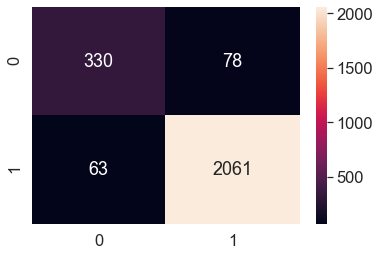

In [677]:
Tree = DecisionTreeClassifier(max_depth = 9, random_state = 44, criterion = 'entropy')
Tree.fit(x_train, y_train)
y_pred = Tree.predict(x_test)


_model_probabilities = Tree.predict_proba(x_train)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_train, _model_probabilities)
Comparison['DecisionTree'] = [metrics.accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), false_positive_rate_values, sensitivity_values, roc_auc_score(y_test, y_pred)]

tree_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(tree_cm, annot=True, fmt="")
plt.show()

In [678]:
print(classification_report(y_test, y_pred))
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100.0))
print("Recall: %.2f%%" % (recall_score(y_test, y_pred)*100.0))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       408
           1       0.96      0.97      0.97      2124

    accuracy                           0.94      2532
   macro avg       0.90      0.89      0.90      2532
weighted avg       0.94      0.94      0.94      2532

Accuracy: 94.43%
Recall: 97.03%


# Random Forest


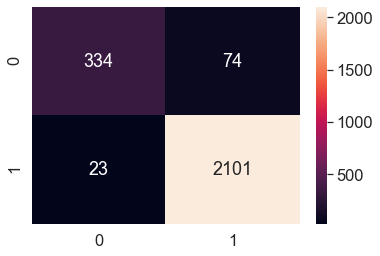

In [679]:
RF = RandomForestClassifier(max_depth=15, max_features='log2')
RF.fit(x_train, y_train)
y_pred = RF.predict(x_test)

_model_probabilities = RF.predict_proba(x_train)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_train, _model_probabilities)
Comparison['RandomForest'] = [metrics.accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), false_positive_rate_values, sensitivity_values, roc_auc_score(y_test, y_pred)]

forest_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(forest_cm, annot=True, fmt="")
plt.show()

In [680]:
print(classification_report(y_test, y_pred))
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100.0))
print("Recall: %.2f%%" % (recall_score(y_test, y_pred)*100.0))

              precision    recall  f1-score   support

           0       0.94      0.82      0.87       408
           1       0.97      0.99      0.98      2124

    accuracy                           0.96      2532
   macro avg       0.95      0.90      0.93      2532
weighted avg       0.96      0.96      0.96      2532

Accuracy: 96.17%
Recall: 98.92%


# Support Vector Machine

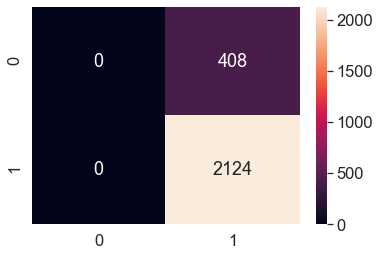

In [681]:
SV = SVC(probability=True)
SV.fit(x_train, y_train)
y_pred = SV.predict(x_test)

_model_probabilities = SV.predict_proba(x_train)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_train, _model_probabilities)
Comparison['SupportVector'] = [metrics.accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), false_positive_rate_values, sensitivity_values, roc_auc_score(y_test, y_pred)]

support_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(support_cm, annot=True, fmt="")
plt.show()

In [682]:
print(classification_report(y_test, y_pred))
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100.0))
print("Recall: %.2f%%" % (recall_score(y_test, y_pred)*100.0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       408
           1       0.84      1.00      0.91      2124

    accuracy                           0.84      2532
   macro avg       0.42      0.50      0.46      2532
weighted avg       0.70      0.84      0.77      2532

Accuracy: 83.89%
Recall: 100.00%


# Gradient Boosting

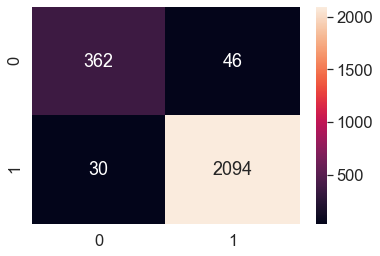

In [683]:
GB = GradientBoostingClassifier(n_estimators = 200, learning_rate = 1, max_depth = 4, random_state = 0)
GB.fit(x_train, y_train)
y_pred = GB.predict(x_test)

_model_probabilities = GB.predict_proba(x_train)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_train, _model_probabilities)
Comparison['GradientBoost'] = [metrics.accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), false_positive_rate_values, sensitivity_values, roc_auc_score(y_test, y_pred)]

gradient_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(gradient_cm, annot=True, fmt="")
plt.show()

In [684]:
print(classification_report(y_test, y_pred))
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100.0))
print("Recall: %.2f%%" % (recall_score(y_test, y_pred)*100.0))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       408
           1       0.98      0.99      0.98      2124

    accuracy                           0.97      2532
   macro avg       0.95      0.94      0.94      2532
weighted avg       0.97      0.97      0.97      2532

Accuracy: 97.00%
Recall: 98.59%


 # XGBoost

[00:04:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:04:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


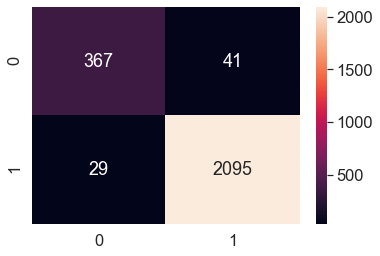

In [685]:
xgboost = XGBClassifier(loss='exponential', n_estimators = 100, max_depth=20, subsample=0.9)
xgboost.fit(x_train, y_train)
y_pred = xgboost.predict(x_test)

_model_probabilities = xgboost.predict_proba(x_train)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_train, _model_probabilities)
Comparison['XGBoost'] = [metrics.accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), false_positive_rate_values, sensitivity_values, roc_auc_score(y_test, y_pred)]

xg_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(xg_cm, annot=True, fmt="")
plt.show()

In [686]:
print(classification_report(y_test, y_pred))
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100.0))
print("Recall: %.2f%%" % (recall_score(y_test, y_pred)*100.0))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       408
           1       0.98      0.99      0.98      2124

    accuracy                           0.97      2532
   macro avg       0.95      0.94      0.95      2532
weighted avg       0.97      0.97      0.97      2532

Accuracy: 97.24%
Recall: 98.63%


# Bagging

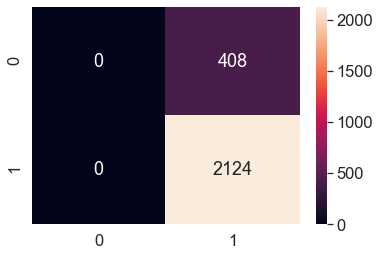

In [687]:
clf = BaggingClassifier(base_estimator=SVC(),n_estimators=10, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

_model_probabilities = clf.predict_proba(x_train)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_train, _model_probabilities)
Comparison['Bagging'] = [metrics.accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), false_positive_rate_values, sensitivity_values, roc_auc_score(y_test, y_pred)]

bagging_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(bagging_cm, annot=True, fmt="")
plt.show()

In [688]:
print(classification_report(y_test, y_pred))
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100.0))
print("Recall: %.2f%%" % (recall_score(y_test, y_pred)*100.0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       408
           1       0.84      1.00      0.91      2124

    accuracy                           0.84      2532
   macro avg       0.42      0.50      0.46      2532
weighted avg       0.70      0.84      0.77      2532

Accuracy: 83.89%
Recall: 100.00%


In [689]:
result = pd.DataFrame.from_dict(Comparison, orient='index').sort_values(0, ascending=False)
result = result.rename(columns={0: 'Accuracy', 1: "Recall", 2: 'FPR', 3: 'Sensitivity', 4: 'AUC'})
result

,Accuracy,Recall,FPR,Sensitivity,AUC
XGBoost,0.972354,0.986347,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00015683814303638644, 0.00078419071518...",0.942928
GradientBoost,0.969984,0.985876,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.008155583437892095, 0.0092534504391468...",0.936565
RandomForest,0.961690,0.989171,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.03372020075282309, 0.03466122961104141...",0.903899
DecisionTree,0.944313,0.970339,"[0.0, 0.0, 0.006562756357670222, 0.00738310090...","[0.0, 0.8607277289836889, 0.9149937264742786, ...",0.889581
Logistic,0.877172,0.959510,"[0.0, 0.0, 0.0, 0.0008203445447087777, 0.00082...","[0.0, 0.00015683814303638644, 0.02619196988707...",0.704020
SupportVector,0.838863,1.000000,"[0.0, 0.0, 0.0, 0.0008203445447087777, 0.00082...","[0.0, 0.00015683814303638644, 0.08171267252195...",0.500000
Bagging,0.838863,1.000000,"[0.0, 1.0]","[0.0, 1.0]",0.500000


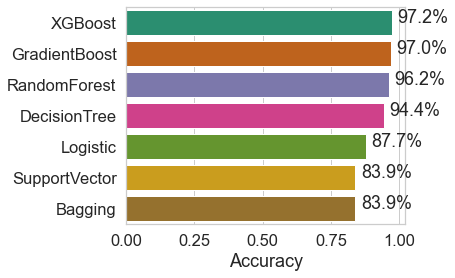

In [690]:
fig, ax = plt.subplots(figsize = (5,4)) 
sns.barplot(x=result['Accuracy'], y=result.index, palette = "Dark2")

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width())
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))

   

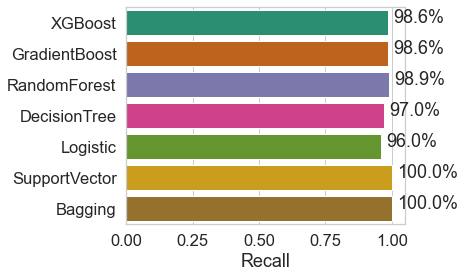

In [691]:
fig, ax = plt.subplots(figsize = (5,4)) 
sns.barplot(x=result['Recall'], y=result.index, palette = "Dark2")
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width())
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))

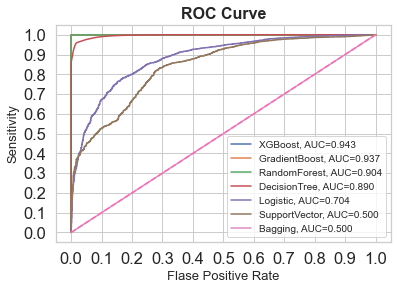

In [692]:
for i in result.index:
    plt.plot(result.loc[i]['FPR'], result.loc[i]['Sensitivity'], label="{}, AUC={:.3f}".format(i, result.loc[i]['AUC']))

plt.plot([0,1], [0,1], color='hotpink', linestyle='--')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=13)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Sensitivity", fontsize=13)
plt.title('ROC Curve', fontweight='bold', fontsize=16)
plt.legend(prop={'size':10}, loc='lower right')

plt.show()